<a href="https://colab.research.google.com/github/yingzibu/a_inhibitor_design/blob/main/examples/fp_multi_label_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!rm -R 'a_inhibitor_design'
! git clone https://github.com/yingzibu/a_inhibitor_design.git --quiet
!rm -R 'JAK_ML'
! git clone https://github.com/yingzibu/JAK_ML.git --quiet
!rm -R 'JAK-MTATFP'
! git clone https://github.com/Yimeng-Wang/JAK-MTATFP.git --quiet

rm: cannot remove 'a_inhibitor_design': No such file or directory
rm: cannot remove 'JAK_ML': No such file or directory
rm: cannot remove 'JAK-MTATFP': No such file or directory


In [ ]:
! pip install pubchempy --quiet
! pip install rdkit --quiet

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np

train_path = '/content/JAK-MTATFP/Data/JAK_train.csv'
valid_path = '/content/JAK-MTATFP/Data/JAK_valid.csv'
test_path = '/content/JAK-MTATFP/Data/JAK_test.csv'
train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)
test_df = pd.read_csv(test_path)

train_df.head(), train_df.shape, valid_df.shape, test_df.shape

In [ ]:
for df in [train_df, valid_df, test_df]:
    for enzyme in ['JAK1', 'JAK2', 'JAK3', 'TYK2']:
        column_name = 'pIC50_' + enzyme
        print(column_name)
        print('min:', df[column_name].min())
        print('max:', df[column_name].max() )

# pIC50 no data -100. IC50 always >0.
# Thus it is safe to replace NaN values to -100
train_df = train_df.fillna(-100)
valid_df = valid_df.fillna(-100)
test_df = test_df.fillna(-100)

In [169]:
import torch.nn as nn
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pickle

class Regressor(nn.Module):
    """
    simple regression, for prediction using
    latent space of dim [batch_size, z_dim]
    """
    def __init__(self, dims):
        """
        :param dims [in_dim, h_dims, out_dim]
            in_dim: input dim
            h_dims: a list of hidden dims
            out_dim: output dim
        """
        super(Regressor, self).__init__()
        [in_dim, h_dims, out_dim] = dims
        self.dims = dims

        neurons = [in_dim, *h_dims]
        linear_layers = [nn.Linear(
            neurons[i-1], neurons[i]
            ) for i in range(1, len(neurons))]

        self.hidden = nn.ModuleList(linear_layers)
        self.final = nn.Linear(h_dims[-1], out_dim)

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
            # print(x.shape) [batch_size, h_dim[-1]]
        x = self.final(x)
        return x



class fp_reg_dataset(Dataset):
    """
    data set for loading data from MTATFP pIC50_enzyme
    using MACCS fingerprint as features
    """
    def __init__(self, df):
        super(fp_reg_dataset, self).__init__()
        self.len = len(df)
        self.df = df
    def __getitem__(self, idx):
        enzymes = ['JAK1', 'JAK2', 'JAK3', 'TYK2']
        header = ['bit' + str(i) for i in range(167)]
        fp = self.df[header]
        fp = torch.tensor([float(b) for b in fp.iloc[idx]], dtype=torch.float32)
        label = [self.df['pIC50_'+enzyme][idx] for enzyme in enzymes]
        # print(label)
        # label = onehot(2)(label)
        label = torch.tensor(label, dtype=torch.float32)
        return fp, label
    def __len__(self):
        return self.len


In [125]:
from JAK_ML.ML_code.function import *

def process(df):
    MACCS_list = smile_list_to_MACCS(df['SMILES'].tolist())
    header = ['bit' + str(i) for i in range(167)]
    new_df = pd.DataFrame(MACCS_list, columns=header)
    for enzyme in ['JAK1', 'JAK2', 'JAK3', 'TYK2']:
        col_name = 'pIC50_'+enzyme
        new_df[col_name] = df[col_name]
    return new_df

train_df_fp = process(train_df)
valid_df_fp = process(valid_df)
test_df_fp = process(test_df)

train = train_df_fp.reset_index(drop=True)
valid = valid_df_fp.reset_index(drop=True)
test = test_df_fp.reset_index(drop=True)

In [129]:
test

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit161,bit162,bit163,bit164,bit165,bit166,pIC50_JAK1,pIC50_JAK2,pIC50_JAK3,pIC50_TYK2
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,-0.903090,-100.000000,-100.000000,-100.000000
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,-2.849419,-3.366983,-100.000000,-100.000000
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,-1.041393,-2.357935,-100.000000,-100.000000
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,0.455932,-0.301030,-100.000000,-100.000000
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,-100.000000,-100.000000,-2.765669,-100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,-100.000000,-100.000000,-100.000000,-2.724276
1540,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,-100.000000,-100.000000,-100.000000,-2.204120
1541,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,-100.000000,-2.836324,-100.000000,-100.000000
1542,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,-100.000000,-100.000000,-100.000000,-1.826075


In [170]:
import os
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.nn import init

train_dataset = fp_reg_dataset(train)
valid_dataset = fp_reg_dataset(valid)
test_dataset = fp_reg_dataset(test)

In [171]:
params = {'batch_size': 16, 'shuffle': True,
          'drop_last': False, 'num_workers': 0}

train_loader = DataLoader(train_dataset, **params)
valid_loader = DataLoader(valid_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

In [148]:
in_dim = 167 # len of fingerprint
hid_dims = [256, 64]
out_dim = 4 # pIC50 of [jak1, jak2, jak3, tyk2]

model = Regressor([in_dim, hid_dims, out_dim])

cuda = torch.cuda.is_available()
if cuda: model = model.cuda()

loss_function = nn.MSELoss()
optimizer = optim.AdamW(params=model.parameters(), lr=1e-3, weight_decay=1e-2)

train_loss_dict = {}
valid_loss_dict = {}

In [182]:
len(train_loader), len(valid_loader)

(677, 96)

epoch 30: 100%|██████████| 677/677 [02:26<00:00,  4.61it/s]


[Train] MSE loss: 0.298
[Valid] MSE loss: 0.485


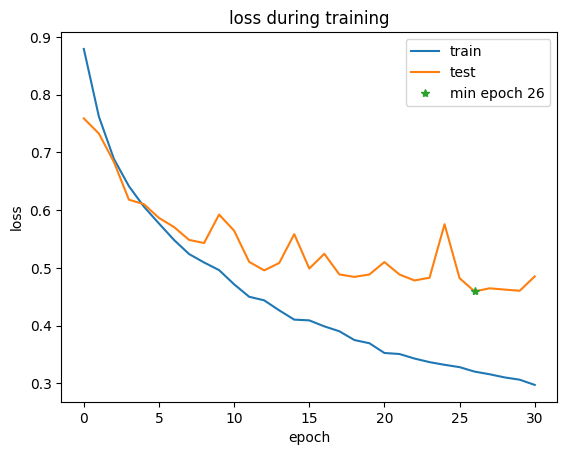

epoch 31: 100%|██████████| 677/677 [02:29<00:00,  4.54it/s]


[Train] MSE loss: 0.296
[Valid] MSE loss: 0.468


epoch 32: 100%|██████████| 677/677 [02:27<00:00,  4.60it/s]


[Train] MSE loss: 0.297
[Valid] MSE loss: 0.492


epoch 33: 100%|██████████| 677/677 [02:28<00:00,  4.57it/s]


[Train] MSE loss: 0.293
[Valid] MSE loss: 0.468


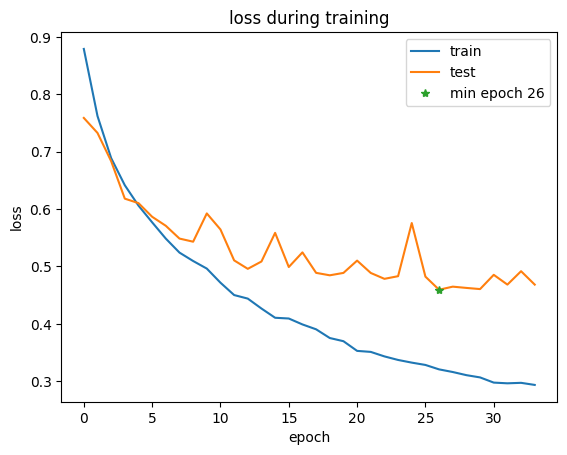

epoch 34: 100%|██████████| 677/677 [02:28<00:00,  4.56it/s]


[Train] MSE loss: 0.288
[Valid] MSE loss: 0.473


epoch 35: 100%|██████████| 677/677 [02:34<00:00,  4.39it/s]


[Train] MSE loss: 0.283
[Valid] MSE loss: 0.461


epoch 36: 100%|██████████| 677/677 [02:30<00:00,  4.50it/s]


[Train] MSE loss: 0.277
[Valid] MSE loss: 0.517


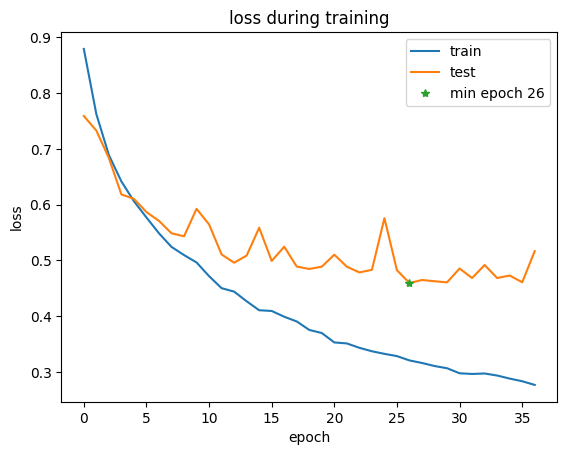

epoch 37: 100%|██████████| 677/677 [02:29<00:00,  4.54it/s]


[Train] MSE loss: 0.277
[Valid] MSE loss: 0.457
current dir:  /content
model saved at:  test_37.pt


epoch 38: 100%|██████████| 677/677 [02:29<00:00,  4.52it/s]


[Train] MSE loss: 0.272
[Valid] MSE loss: 0.461


epoch 39: 100%|██████████| 677/677 [02:28<00:00,  4.57it/s]


[Train] MSE loss: 0.268
[Valid] MSE loss: 0.460


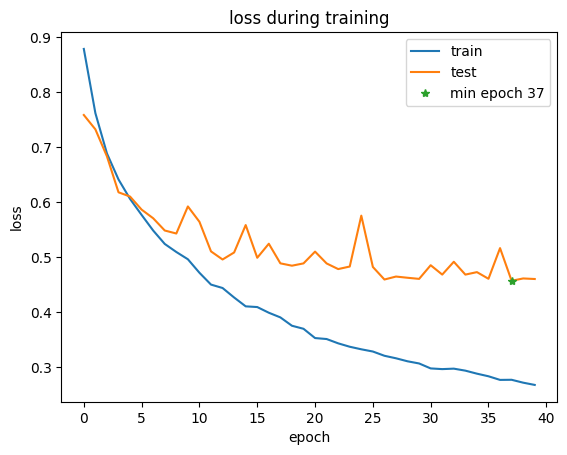

epoch 40: 100%|██████████| 677/677 [02:27<00:00,  4.60it/s]


[Train] MSE loss: 0.265
[Valid] MSE loss: 0.471


epoch 41: 100%|██████████| 677/677 [02:26<00:00,  4.63it/s]


[Train] MSE loss: 0.266
[Valid] MSE loss: 0.447
current dir:  /content
model saved at:  test_41.pt


epoch 42: 100%|██████████| 677/677 [02:25<00:00,  4.64it/s]


[Train] MSE loss: 0.264
[Valid] MSE loss: 0.456


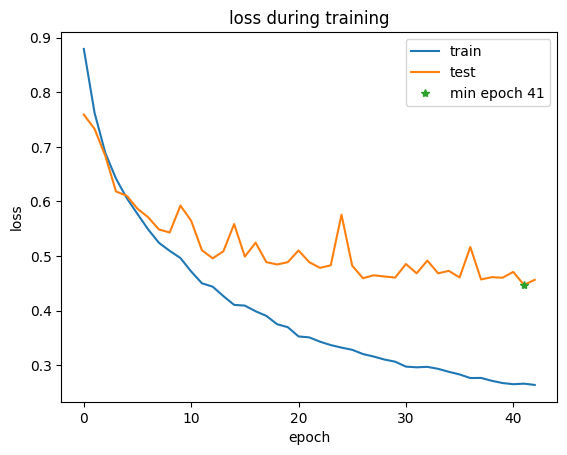

epoch 43: 100%|██████████| 677/677 [02:30<00:00,  4.50it/s]


[Train] MSE loss: 0.259
[Valid] MSE loss: 0.464


epoch 44: 100%|██████████| 677/677 [02:42<00:00,  4.16it/s]


[Train] MSE loss: 0.256
[Valid] MSE loss: 0.480


epoch 45: 100%|██████████| 677/677 [02:32<00:00,  4.43it/s]


[Train] MSE loss: 0.251
[Valid] MSE loss: 0.478


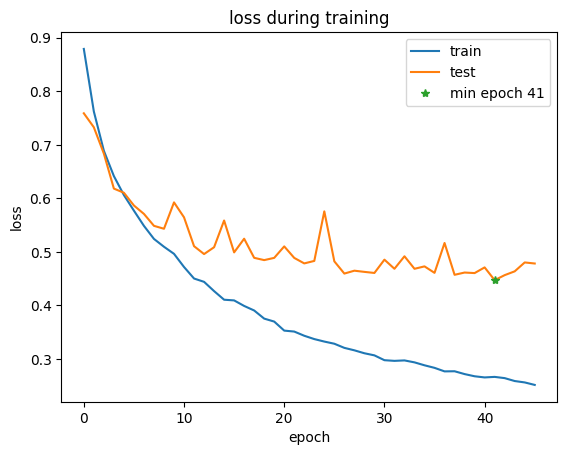

epoch 46: 100%|██████████| 677/677 [02:27<00:00,  4.58it/s]


[Train] MSE loss: 0.256
[Valid] MSE loss: 0.452


epoch 47: 100%|██████████| 677/677 [02:27<00:00,  4.59it/s]


[Train] MSE loss: 0.255
[Valid] MSE loss: 0.444
current dir:  /content
model saved at:  test_47.pt


epoch 48: 100%|██████████| 677/677 [02:27<00:00,  4.58it/s]


[Train] MSE loss: 0.246
[Valid] MSE loss: 0.460


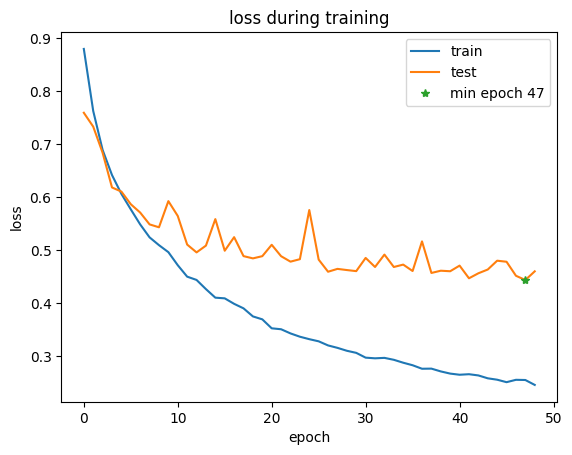

epoch 49: 100%|██████████| 677/677 [02:30<00:00,  4.49it/s]


[Train] MSE loss: 0.249
[Valid] MSE loss: 0.484


epoch 50: 100%|██████████| 677/677 [02:29<00:00,  4.51it/s]


[Train] MSE loss: 0.243
[Valid] MSE loss: 0.445


epoch 51: 100%|██████████| 677/677 [02:30<00:00,  4.50it/s]


[Train] MSE loss: 0.245
[Valid] MSE loss: 0.459


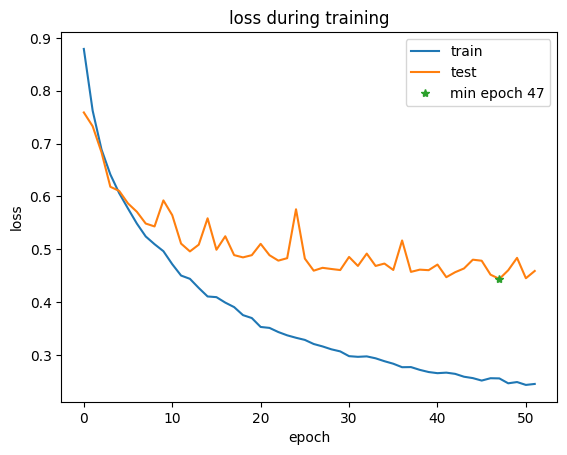

epoch 52: 100%|██████████| 677/677 [02:30<00:00,  4.51it/s]


[Train] MSE loss: 0.235
[Valid] MSE loss: 0.497


epoch 53: 100%|██████████| 677/677 [02:29<00:00,  4.53it/s]


[Train] MSE loss: 0.241
[Valid] MSE loss: 0.461


epoch 54: 100%|██████████| 677/677 [02:29<00:00,  4.53it/s]


[Train] MSE loss: 0.240
[Valid] MSE loss: 0.436


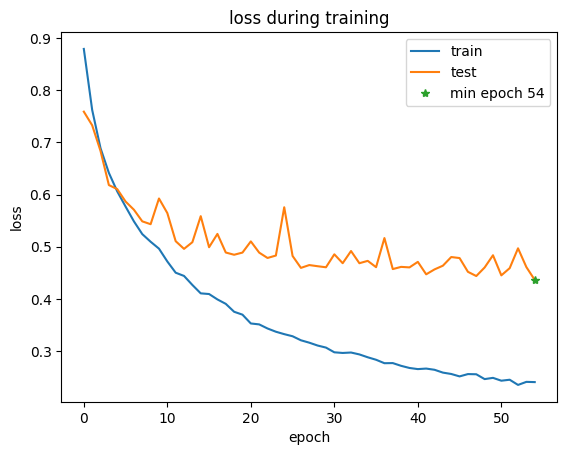

current dir:  /content
model saved at:  test_54.pt


epoch 55: 100%|██████████| 677/677 [02:30<00:00,  4.51it/s]


[Train] MSE loss: 0.240
[Valid] MSE loss: 0.448


epoch 56: 100%|██████████| 677/677 [02:28<00:00,  4.56it/s]


[Train] MSE loss: 0.231
[Valid] MSE loss: 0.464


epoch 57: 100%|██████████| 677/677 [02:29<00:00,  4.53it/s]


[Train] MSE loss: 0.233
[Valid] MSE loss: 0.448


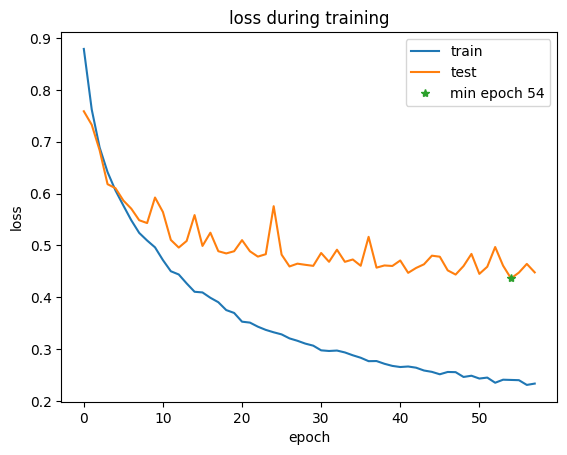

epoch 58: 100%|██████████| 677/677 [02:29<00:00,  4.52it/s]


[Train] MSE loss: 0.236
[Valid] MSE loss: 0.484


epoch 59: 100%|██████████| 677/677 [02:29<00:00,  4.51it/s]


[Train] MSE loss: 0.225
[Valid] MSE loss: 0.494


epoch 60: 100%|██████████| 677/677 [02:30<00:00,  4.50it/s]


[Train] MSE loss: 0.229
[Valid] MSE loss: 0.469


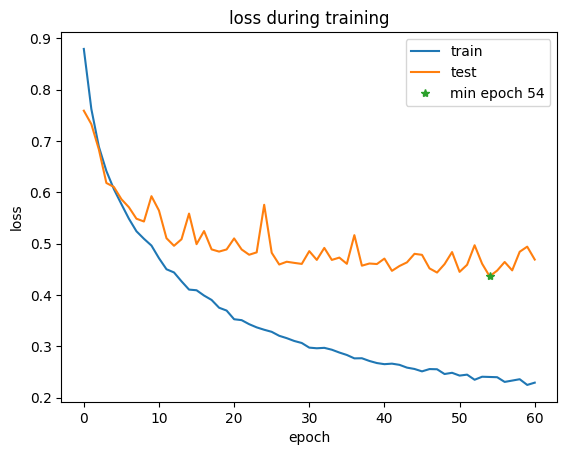

epoch 61: 100%|██████████| 677/677 [02:32<00:00,  4.44it/s]


[Train] MSE loss: 0.228
[Valid] MSE loss: 0.461


epoch 62: 100%|██████████| 677/677 [02:49<00:00,  3.99it/s]


[Train] MSE loss: 0.226
[Valid] MSE loss: 0.437


epoch 63: 100%|██████████| 677/677 [02:56<00:00,  3.84it/s]


[Train] MSE loss: 0.223
[Valid] MSE loss: 0.489


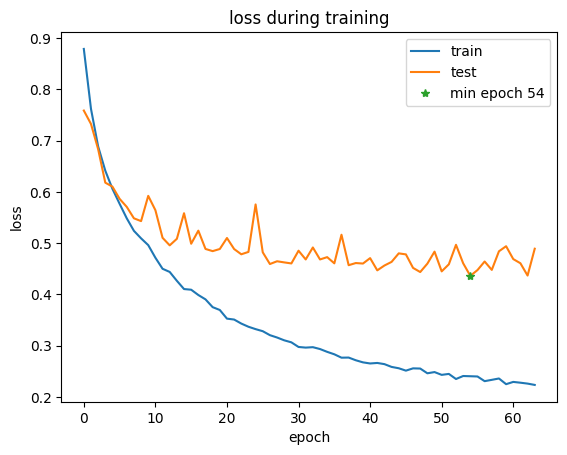

epoch 64: 100%|██████████| 677/677 [02:55<00:00,  3.85it/s]


[Train] MSE loss: 0.226
[Valid] MSE loss: 0.448


epoch 65: 100%|██████████| 677/677 [02:35<00:00,  4.36it/s]


[Train] MSE loss: 0.220
[Valid] MSE loss: 0.458
early stop, no decrease


In [184]:
from a_inhibitor_design.model.evaluate_utils import get_min, plot_loss

epochs = 100


for epoch in range(epochs):
    total_loss = 0
    model.train()
    for i, (fp, label) in tqdm(enumerate(train_loader),
                               total=len(train_loader),
                               desc=f'epoch {epoch}'):
        optimizer.zero_grad()
        if cuda:
            fp, label = fp.float().cuda(), label.cuda()
        mask = label == -100
        output = model(fp)
        loss = loss_function(output[~mask], label[~mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    total_loss /= len(train_loader)
    print(f'[Train] MSE loss: {total_loss:.3f}')
    train_loss_dict[epoch] = total_loss

    model.eval()
    total_valid_loss = 0

    for fp, label in valid_loader:
        if cuda:
            fp, label = fp.float().cuda(), label.cuda()
        mask = label == -100
        output = model(fp)
        loss = loss_function(output[~mask], label[~mask])
        total_valid_loss += loss.item()

    total_valid_loss /= len(valid_loader)
    print(f'[Valid] MSE loss: {total_valid_loss:.3f}')

    valid_loss_dict[epoch] = total_valid_loss

    if epoch %3 == 0 and epoch != 0:
        plot_loss(train_loss_dict, valid_loss_dict)

    argmin, min_loss = get_min(valid_loss_dict)

    if total_valid_loss <= min_loss and epoch > 3:
        torch.save(model.state_dict(), f'test_{str(epoch)}.pt')
        best_epoch = epoch
        print('current dir: ', os.getcwd())
        print('model saved at: ', f'test_{str(epoch)}.pt')
    else:
        if epoch - argmin > 10:
            print('early stop, no decrease')
            break
        if total_valid_loss / min_loss > 1.3:
            print('early stop, large loss increase')
            break

54

In [ ]:
def save(model, name):
    # name_only = name.split('.')[0]
    assert name.split('.')[1] == 'pt'
    # with open(name_only+'.pkl', 'wb') as f:
    #     pickle.dump(model.dims, f)
    torch.save(model.state_dict(), name)
    print('model saved at: ', name)

def load(model, name):
    name_only = name.split('.')[0]
    assert name.split('.')[1] == 'pt'
    # with open(name_only+'.pkl', 'rb') as f:
    #     dims = pickle.load(f)
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(name), map_location='cuda')
    else: model.load_state_dict(torch.load(name), map_location='cpu')

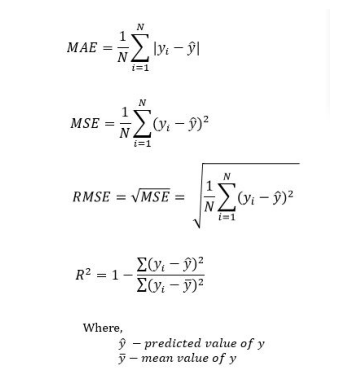

In [7]:
! wget https://1.bp.blogspot.com/-IXZrfXmG5Hs/XZvl6zHgwLI/AAAAAAAAAhw/-XoWPQLbkG4f-R6kQ7M4HxSOfP15KEAEwCLcBGAsYHQ/s1600/formula-MAE-MSE-RMSE-RSquared.JPG --quiet
# ! pip install Pillow --quiet
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/formula-MAE-MSE-RMSE-RSquared.JPG')
plt.imshow(img)
plt.axis('off')
plt.show()

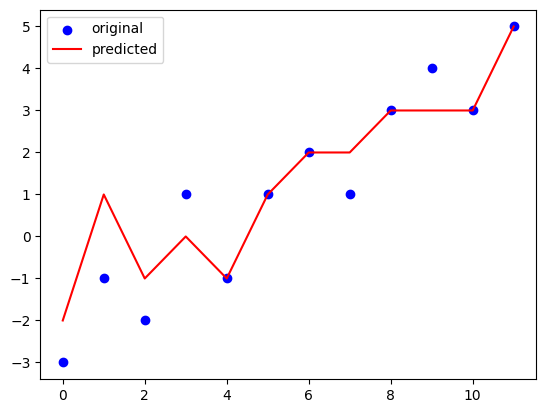

Results by manual calculation:
MAE: 0.5833333333333334
MSE: 0.75
RMSE: 0.8660254037844386
R-Squared: 0.8655043586550436
Results of sklearn.metrics:
MAE: 0.5833333333333334
MSE: 0.75
RMSE: 0.8660254037844386
R-Squared: 0.8655043586550436


In [185]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

y = np.array([-3, -1, -2, 1, -1, 1, 2, 1, 3, 4, 3, 5])
yhat = np.array([-2, 1, -1, 0, -1, 1, 2, 2, 3, 3, 3, 5])
x = list(range(len(y)))


# We can visualize them in a plot to check the difference visually.

plt.scatter(x, y, color="blue", label="original")
plt.plot(x, yhat, color="red", label="predicted")
plt.legend()
plt.show()


d = y - yhat
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)
r2_f = 1-(sum(d**2)/sum((y-np.mean(y))**2))

print("Results by manual calculation:")
print("MAE:",mae_f)
print("MSE:", mse_f)
print("RMSE:", rmse_f)
print("R-Squared:", r2_f)


mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse) #mse**(0.5)
r2 = metrics.r2_score(y,yhat)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)


In [ ]:
# Reload model
model_ = Regressor([in_dim, hid_dims, out_dim])
# if cuda: model_ = model_.cuda()
# best_epoch = 1
model_path = f'test_{best_epoch}.pt'
if cuda:
    model_.load_state_dict(torch.load(model_path), map_location='cuda')
# y_preds = []
# y_trues = []
# y_probs = []
# for fp, label in enumerate(test_loader):
#     if cuda: